# Análise do Data Warehouse - (Cursos Superior, Cor/Raça, IFPB)

Análise dos dados disponibilizados no Data Warehouse



**Instalando o Cassandra no Jupyter**

`docker-compose exec jupyter pip install cassandra-driver`

## Imports

In [1]:
#Imports
from time import sleep

In [2]:
#Imports Cassandra
from cassandra.auth import PlainTextAuthProvider
from cassandra.cluster import Cluster

In [3]:
#Imports Pandas
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

## Conexão ao banco de Dados Cassandra

In [4]:
#Conectando a seção
ap = PlainTextAuthProvider(username='cassandra', password='cassandra')
cluster = Cluster(['cassandra'], protocol_version=4, auth_provider=ap)
session = cluster.connect('alunos')
session.default_timeout = 60
session.row_factory = pandas_factory
sleep(2)

## Consulta

In [5]:
table = 'fato_aluno_cor'
field = 'cor_raca'
curse_types = ['Bacharelado','Licenciatura','Tecnologia']
filters = {    
    'categoria_situacao': ['Evadidos','Concluintes'],
    'unidade_ensino': '',
    'instituicao': '',
}

In [6]:
s = []
for k, v in filters.items():
    if v :
        if type(v) is str:
            s.append("({} = '{}')".format(k,v))
        elif type(v) is list:
            s.append("({} IN ({}))".format(
                k,
                ','.join(map(str,["'{}'".format(i) for i in v]))))
filter_sql = " AND ".join(map(str,s))

In [7]:
# Análise de Sexo
sql = "SELECT categoria_situacao, {0}, tipo_curso, instituicao, unidade_ensino, sum(quant_grupo) AS quant_grupo" \
" FROM {1} " \
" WHERE {2} " \
" GROUP BY categoria_situacao, {0}, tipo_curso, instituicao " \
" ALLOW FILTERING;".format(
    field, 
    table,
    filter_sql)
rslt = session.execute(sql, timeout=None)
df = rslt._current_rows
df

,categoria_situacao,cor_raca,tipo_curso,instituicao,unidade_ensino,quant_grupo
0,Concluintes,Amarela,Bacharelado,CEFET-MG,Uned Araxá,19
1,Concluintes,Amarela,Bacharelado,IF GOIANO,Campus Ceres,5
2,Concluintes,Amarela,Bacharelado,IF SERTAO-PE,Campus Petrolina Zona Rural,1
3,Concluintes,Amarela,Bacharelado,IF SUDESTE MG,Campus Rio Pomba,1
4,Concluintes,Amarela,Bacharelado,IFBA,Campus Paulo Afonso,2
...,...,...,...,...,...,...
3185,Evadidos,Preta,Técnico,UFSM - POLITECNICO,Colégio Politécnico da UFSM,10
3186,Evadidos,Preta,Técnico,UFSM - POLITÉCNICO,Colégio Politécnico da Universidade Federal Sa...,7
3187,Evadidos,Preta,Técnico,UFTM - CEFORES,Centro de Formação Especial em Saúde da UFTM,19
3188,Evadidos,Preta,Técnico,UFU - ESTES,Escola Técnica de Saúde da UFU,27


## Filtrando Tipo do Curso

In [8]:
if curse_types :
    df = df[df['tipo_curso'].isin(curse_types)]
    print('Fitrando pelos tipos de cursos:\n {}'.format(', '.join(map(str,curse_types))))
    
else:
    print('Todos os cursos')
df

Fitrando pelos tipos de cursos:
 Bacharelado, Licenciatura, Tecnologia


,categoria_situacao,cor_raca,tipo_curso,instituicao,unidade_ensino,quant_grupo
0,Concluintes,Amarela,Bacharelado,CEFET-MG,Uned Araxá,19
1,Concluintes,Amarela,Bacharelado,IF GOIANO,Campus Ceres,5
2,Concluintes,Amarela,Bacharelado,IF SERTAO-PE,Campus Petrolina Zona Rural,1
3,Concluintes,Amarela,Bacharelado,IF SUDESTE MG,Campus Rio Pomba,1
4,Concluintes,Amarela,Bacharelado,IFBA,Campus Paulo Afonso,2
...,...,...,...,...,...,...
3120,Evadidos,Preta,Tecnologia,IFSULDEMINAS,Campus Inconfidentes,9
3121,Evadidos,Preta,Tecnologia,IFTM,Campus Avançado Uberaba Parque Tecnológico,78
3122,Evadidos,Preta,Tecnologia,IFTO,Campus Araguaína,100
3123,Evadidos,Preta,Tecnologia,UFSM - CTISM,Colégio Técnico Industrial da Universidade Fed...,1


## Agrupando

In [9]:
df = df.groupby(['categoria_situacao',field]).sum('quant_grupo').reset_index()

<AxesSubplot:xlabel='cor_raca'>

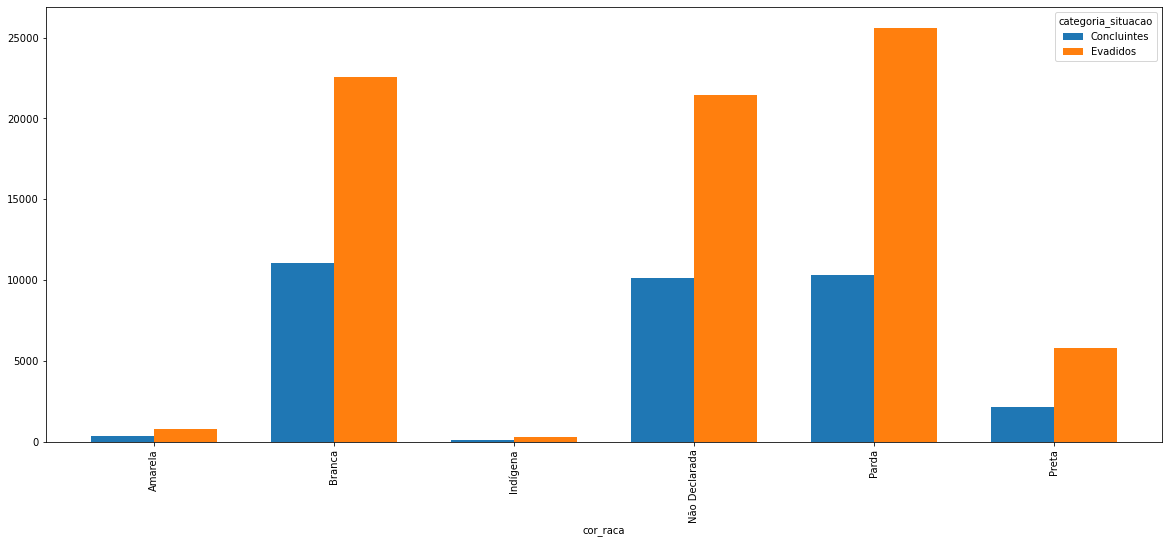

In [10]:
x = df.pivot_table('quant_grupo',[field],'categoria_situacao')
#x = df.pivot_table('quant_grupo',['categoria_situacao'],field)
x.plot(kind ='bar', figsize=(20, 8), width = 0.7)

## Total de Alunos

In [11]:
#df[field]
df.groupby([field]).sum('quant_grupo')['quant_grupo']

cor_raca
Amarela           1174
Branca           33633
Indígena           417
Não Declarada    31565
Parda            35953
Preta             7975
Name: quant_grupo, dtype: int64

In [12]:
print("Total de aluns: {:,}".format(df['quant_grupo'].sum()).replace(',','.'))

Total de aluns: 110.717
